In [1]:
from santorinigo.environment import Santorini
from santorinigo.network import ActorCritic
from santorinigo.memory import VanillaMemory

from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import numpy as np

#torch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
from torch.distributions import Categorical

#hyperparameters from https://medium.com/aureliantactics/ppo-hyperparameters-and-ranges-6fc2d29bccbe

## Environment

In [2]:
env = Santorini()
env.print_board()

Buildings:
 [[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
Workers:
 [[ 0  0 -1  0  0]
 [ 0  0  0  0  0]
 [ 1  0  0  0  2]
 [ 0  0  0  0  0]
 [ 0  0 -2  0  0]]
Parts:
 [[ 0  0  0  0  0]
 [ 0 22  0  0  0]
 [ 0  0 18  0  0]
 [ 0  0  0 14  0]
 [ 0  0  0  0 18]]


In [3]:
# ts=[]
# for e in tqdm_notebook(range(100)):
#     t=0
#     env = Santorini()
#     state = env.get_state()
#     while True:
#         t+=1
#         legal_moves = env.legal_moves()
#         if not legal_moves: break
#         action = np.random.choice(legal_moves) if len(legal_moves) > 1 else legal_moves[0]
#         next_state,reward,done,_ = env.step(action)
#         if done:
#             ts.append(t)
#             break
# plt.hist(ts,bins=100)

## N-Step Bootstrapping
Let $\delta_t$ be the TD error at timestep t:
$$\delta_t = r_t + \gamma V(s_{t+1}) - V(s_t)$$

k-step bootstrap advantage can be written as:

$$A^{k}_{t} = \delta_t + \gamma\delta_{t+1} + ... + \gamma^{k}\delta_{t+k-1}$$

$$A^{k}_{t} = -V(s_t) + r_t + \gamma V(s_{t+1}) + \gamma \biggl[ r_{t+1} + \gamma V(s_{t+2}) - V(s_{t+1}) \biggl] + ...$$

$$A^{k}_{t} = -V(s_t) + \Sigma^{k-1}_{i=0} \gamma^{i}r_{t+1} +\gamma^kV(s_{t+k})$$

1-step bootstrap advantage is TD error:

$$A^{1}_{t} = \delta_t = r_t + \gamma V(s_{t+1}) - V(s_t)$$

Infinite-step bootstrap advantage is Monte Carlo estimate:

$$A^{\infty}_{t} = -V(s_t) + \Sigma^{\infty}_{i=0} \gamma^{i}r_{t+1}$$

## Generalized Advantage Estimation (GAE) Returns

Weighted average of $A^0_t$ to $A^k_t$ with hyperparameter $\lambda$

$$A^{GAE}_t = (1-\lambda)\biggl( A^{1}_t + A^{2}_t + ... \biggl)$$
$$A^{GAE}_t = (1-\lambda)\biggl( \delta_t + \lambda (\delta_t + \gamma \delta_{t+1}) + \lambda^2 (\delta_t + \gamma \delta_{t+1} + \gamma^2 \delta_{t+2}) + ... \biggl)$$
$$A^{GAE}_t = (1-\lambda)\biggl( \delta_t(1+\lambda+\lambda^2+...) + \gamma\delta_{t+1}(\lambda+\lambda^2+\lambda^3+...) + ...\biggl)$$
$$A^{GAE}_t = (1-\lambda)\biggl( \delta_t(\frac{1}{1-\lambda}) + \gamma\delta_{t+1}(\frac{\lambda}{1-\lambda}) + ...\biggl)$$

$$A^{GAE}_t = \Sigma_{i=0}^{\infty}(\lambda\gamma)^i \delta_{t+i}$$

In [4]:
def gae_returns(rewards, values, dones, gamma=0.99, tau=0.95):
    gae = 0
    returns = []
    for step in reversed(range(len(rewards))):
        delta = rewards[step] + gamma * values[step + 1] * (1-dones[step]) - values[step]
        gae = delta + gamma * tau * (1-dones[step]) * gae
        returns.insert(0, gae + values[step]) #plus values back to convert advantage to returns
    return(returns)

def future_returns(rewards, dones, gamma=0.99):
    g = 0
    returns = []
    for step in reversed(range(len(rewards))):
        g = rewards[step] + gamma * g * (1-dones[step])
        returns.insert(0, g)
    return(returns)

## Play Episode and Get Trajectory

In [233]:
def play_episode(env, policy, tmax=100, random_actions=False, deterministic=False):
    
    #initialize trajectory
    states    = []
    actions   = []
    log_probs = []
    values    = []
    rewards   = []
    dones     = []
    
    #initialize state and policy
    state = env.reset()
    
    for t in range(tmax):
        state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        
        #policy-based actions
        dist, value = policy(state)
        action = dist.sample()
        if deterministic: action = torch.argmax(dist.probs)[None,]
        
        if random_actions:
            #random legal actions
            legal_moves = env.legal_moves()
            action = np.random.choice(legal_moves) if len(legal_moves) > 0 else 0
            action = torch.tensor(action, dtype=torch.float32, device=device).unsqueeze(0)
        
        #logprob and value
        log_prob = dist.log_prob(action).cpu().detach().numpy()[0]
        value = value.cpu().detach().numpy()[0,0]
        
        
        #convert back to numpy / scalar
        action = int(action.cpu().detach().numpy()[0])
        state = state.cpu().detach().numpy()
        
        #env step
        next_state,reward,done,current_player = env.step(action)
        
        # store the result
        states.append(state)
        actions.append(action)
        log_probs.append(log_prob)
        values.append(value)
        rewards.append(reward)
        dones.append(done)

        state = next_state
        if done: 
            state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
            dist, value = policy(state)
            value = value.cpu().detach().numpy()[0,0]
            values.append(value)
            break
            
    #calculate GAE
    rets = gae_returns(rewards,values,dones)
    advantages = [r - v for r in rets for v in values]
    return(states,actions,log_probs,rets,advantages)

## Update Network

In [162]:
def ppo_update(model, memory, bs=5, epsilon=0.2, beta=0.01):
    if len(memory) < bs: return(0,0,0)
    state, action, old_log_prob, ret, advantage = memory.sample(bs)
    dist, value = model(state)
    entropy = dist.entropy().mean()
    new_log_prob = dist.logits.gather(1,action.long())
    
    #calculate ratio and clipped surrogate
    ratio = (new_log_prob - old_log_prob).exp()
    surr1 = ratio * advantage
    surr2 = torch.clamp(ratio, 1.0 - epsilon, 1.0 + epsilon) * advantage

    #maximize surrogate function
    actor_loss  = -torch.min(surr1, surr2).mean()
    #difference between GAE returns and new value as loss for critic
    critic_loss = F.mse_loss(ret,value)
    loss = (0.5 * critic_loss) + (actor_loss) - (beta * entropy) #critic, action, regularization

    #backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return(loss,actor_loss,critic_loss)

## Training

In [329]:
env = Santorini(winning_floor=3, history_len = 3)
model = ActorCritic((16,5,5),128)
memory = VanillaMemory(int(1e5))
optimizer = optim.Adam(model.parameters(), lr=3e-4)

losses = []
actor_losses = []
critic_losses = []
ts = []
wins = []
epsilon = 0.2
beta = 1e-2

#warm up memory with random episodes
# for i in tqdm_notebook(range(100)):
#     states,actions,log_probs,rets,advantages = play_episode(env,model,random_actions=True)
#     for state, action, log_prob, ret, advantage in zip(states, actions, log_probs, rets, advantages):
#         memory.add(state, action, log_prob, ret, advantage)
# len(memory)

In [330]:
states,actions,log_probs,rets,advantages = play_episode(env,model,random_actions=True)
len(states)

35

In [332]:
bs = 10
update_times = 10

for i in tqdm_notebook(range(1000)):
    #collect trajectories
    memory = VanillaMemory(int(1e3))
    random_flag = True if i % 2==0 else False
    states,actions,log_probs,rets,advantages = play_episode(env,model,random_actions=random_flag)
    ts.append(len(states))
    for state, action, log_prob, ret, advantage in zip(states, actions, log_probs, rets, advantages):
        memory.add(state, action, log_prob, ret, advantage)
    
    #update
    for _ in range(update_times):
        l, a, c = ppo_update(model,memory,bs=5, epsilon=epsilon, beta=beta)
    
    #anneal hyperparameters
#     epsilon*=.999
#     beta*=.995
    
    #record
    losses.append(l)
    actor_losses.append(a)
    critic_losses.append(c)
    wins.append(1 if rets[-1]==1 else 0)
    

KeyboardInterrupt: 

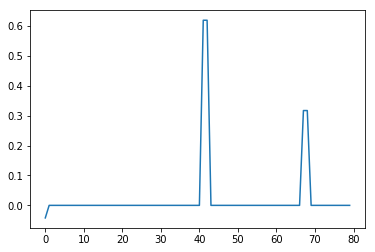

In [333]:
plt.plot(actor_losses)

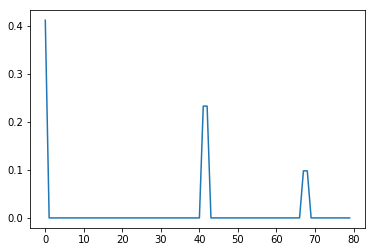

In [334]:
plt.plot(critic_losses)

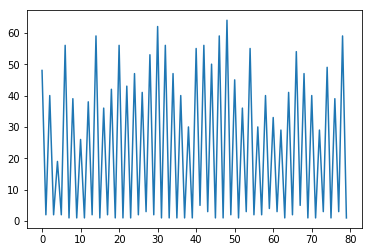

In [335]:
plt.plot(ts)

In [336]:
np.mean(wins)

0.4875

In [337]:
wins = []
for i in tqdm_notebook(range(100)):
    states,actions,log_probs,rets,advantages = play_episode(env,model,random_actions=False)
    if rets[-1]==1:
        wins.append(1)
    else:
        wins.append(0)
np.mean(wins)

0.0

In [338]:
wins = []
for i in tqdm_notebook(range(100)):
    states,actions,log_probs,rets,advantages = play_episode(env,model,random_actions=False,
                                                           deterministic=True)
    if rets[-1]==1:
        wins.append(1)
    else:
        wins.append(0)
np.mean(wins)

0.0

In [297]:
rets

[-0.832875850633666, -0.8980824273526669, -1.0]

In [298]:
[env.itoa[a] for a in actions]

[(-2, 'd', 'd'), (-2, 'z', 'z'), (-2, 'w', 'x')]

In [299]:
state = torch.FloatTensor(env.reset()).unsqueeze(0)

In [300]:
dist,value = model(state)

In [301]:
dist.probs.detach().numpy()

array([[0.00010345, 0.00090548, 0.00121273, 0.01674838, 0.00518168,
        0.00078223, 0.00295611, 0.00167794, 0.0014934 , 0.00363579,
        0.00253957, 0.00713722, 0.00549415, 0.00339692, 0.00375395,
        0.00894033, 0.00122067, 0.0060496 , 0.00248325, 0.00562385,
        0.00276573, 0.00770475, 0.00322179, 0.00547973, 0.0223842 ,
        0.00760096, 0.00388381, 0.0102189 , 0.0088753 , 0.00734649,
        0.00892943, 0.01166737, 0.00431235, 0.00401669, 0.00260887,
        0.01172837, 0.00750936, 0.01146416, 0.01300342, 0.00734448,
        0.00791293, 0.0083561 , 0.00789236, 0.01282131, 0.01715736,
        0.0070944 , 0.01836511, 0.00593354, 0.00865561, 0.01978805,
        0.00647608, 0.00925829, 0.01134466, 0.02252666, 0.00815961,
        0.00922123, 0.00866179, 0.01655166, 0.01253306, 0.01044036,
        0.00668137, 0.01013169, 0.00841211, 0.00442572, 0.00741118,
        0.00521449, 0.00615948, 0.00879585, 0.01440174, 0.0085002 ,
        0.00493587, 0.00973199, 0.0230356 , 0.00

In [292]:
best_opening = np.argmax(dist.probs.detach().numpy())

In [293]:
env.itoa[best_opening]

(-2, 'a', 'q')

In [294]:
env.print_board()

Buildings:
 [[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
Workers:
 [[ 0  0 -1  0  0]
 [ 0  0  0  0  0]
 [ 1  0  0  0  2]
 [ 0  0  0  0  0]
 [ 0  0 -2  0  0]]
Parts:
 [[ 0  0  0  0  0]
 [ 0 22  0  0  0]
 [ 0  0 18  0  0]
 [ 0  0  0 14  0]
 [ 0  0  0  0 18]]
